In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.transforms as mtransforms
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from itertools import chain
from sys import platform
from copy import deepcopy as dc
from scipy.interpolate import interp1d
from astropy.time import Time
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
vims_wave = np.loadtxt('vims_wave.txt')

new_array = ['_0405','_0607','_0809','_1011','_1213','_1415','_1617']
if platform == 'darwin' or platform == 'win32' or platform == 'linux':
    for number in new_array:
        new_string = 'df'+number+' = pd.read_pickle("total_data/data'+number+'.pkl")'
        exec(new_string)
else:
    df_list = []
    for number in new_array:
        new_string = 'df'+number+' = pd.read_csv("total_data/data'+number+'.csv")'
        exec(new_string)
        df_list.append(locals()['df'+number])
    for df in df_list:
        for i in range(len(df['spectrum'])):
            df['spectrum'][i] = np.array([float(x) for x in df['spectrum'][i][1:-1].split(',')])

vims_list = []
for i in range(4,18):
    if i<10:
        exec('vims_200'+str(i)+' = np.load("vims_shift/vims_200'+str(i)+'.npy")')
        vims_list.append(locals()['vims_200'+str(i)])
    else:
        exec('vims_20'+str(i)+' = np.load("vims_shift/vims_20'+str(i)+'.npy")')
        vims_list.append(locals()['vims_20'+str(i)])

def powerlaw(x,a,b):
    return a*np.power(x,b)

def gaussian(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def flatten(some_list):
    flat_list = []
    for element in some_list:
        if type(element) is list or type(element) is tuple:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

band_channels = list(chain(range(29,35),range(46,60),range(78,96),range(102,106)))

window = list(range(56,83))

def fit_line(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_fit = powerlaw(vims_wave,*my_fit)
    return final_fit

def custom_fit(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_spectra = spectra-powerlaw(vims_wave,*my_fit)
    return final_spectra

def single_fit(spectrum):
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectrum[band_channels],p0=[.15,-12])
    final_spectrum = spectrum-powerlaw(vims_wave,*my_fit)
    return final_spectrum

def shift_ret(spectrum):
    my_fit,_ = curve_fit(gaussian,vims_wave[window],spectrum[window],p0=[.05,2.05])
    return my_fit[1]

In [2]:
scatter_list = []
for number in new_array:
    my_string = 'scatter'+number+" = df"+number
    exec(my_string)
    scatter_list.append(locals()['scatter'+number])

airmass_data = pd.concat(scatter_list,ignore_index=True)

all_spectra = []
for i in range(len(airmass_data['spectrum'])):
    all_spectra.append(airmass_data['spectrum'][i])
all_spectra = np.asarray(all_spectra)

airmass_data['emission'] *= (np.pi)/180
airmass_data['incidence'] *= (np.pi)/180

#Convert all necessary data to arrays
emission_vals = np.asarray(airmass_data['emission'])
incidence_vals = np.asarray(airmass_data['incidence'])
start_vals = np.asarray(airmass_data['starttime'])
orig_dates = dc(start_vals)
orig_spectra = dc(all_spectra)


#Find where spectra have "bad" values and delete them from the dataset
bad_ind = np.where(all_spectra[:,69]<=.001)
all_spectra = np.delete(all_spectra,bad_ind,axis=0)
incidence_vals = np.delete(incidence_vals,bad_ind)
emission_vals = np.delete(emission_vals,bad_ind)
start_vals = np.delete(start_vals,bad_ind)

raw_spectra = dc(all_spectra)

#Filtering round 1 (2.2-2.4 µm) - keeping only the 50th percentile of data in to remove outliers - as the composition should be uniform throughout - only interested in dune material
p25 = np.percentile(all_spectra[:,69],25)
p75 = np.percentile(all_spectra[:,69],75)
inds = np.where((all_spectra[:,69] <= p25) | (all_spectra[:,69] >= p75))
# Delete all bad indices from data
all_spectra = np.delete(all_spectra,inds,axis=0)
incidence_vals = np.delete(incidence_vals,inds,axis=0)
emission_vals = np.delete(emission_vals,inds,axis=0)
start_vals = np.delete(start_vals,inds,axis=0)

# for i in band_channels:
#     filtered = False
#     k = 0
#     while filtered == False:
#         mean_1 = np.mean(all_spectra[:,i])
#         median = np.median(all_spectra[:,i])
#         std = np.std(all_spectra[:,i])
#         vals = all_spectra[:,i]
#         ind = np.where(np.abs(vals-mean_1)>=1*std)
#         all_spectra[ind,i] = mean_1+(1*std)
#         mean_2 = np.mean(all_spectra[:,i])
#         k += 1
#         if np.abs(mean_1-mean_2) <= .05*mean_1:
#             filtered = True

#Average scaling correction WITHOUT cos(i) dependence - takes its place

aref = np.average(all_spectra[0,band_channels]) # average of every spectrum at window channels specified in array
cor = (aref/(np.average(all_spectra[:,band_channels],axis=1))) # correction factor
all_spectra *= cor[:,None] # scales data to fit

#Iterative filtering process per channel (256)

for i in range(256):
    filtered = False
    k = 0
    while filtered == False:
        mean_1 = np.mean(all_spectra[:,i])
        median = np.median(all_spectra[:,i])
        std = np.std(all_spectra[:,i])
        vals = all_spectra[:,i]
        ind = np.where(np.abs(vals-mean_1)>=3*std)
        all_spectra[ind,i] = mean_1+(3*std) # if val < mean do subtraction, else add
        mean_2 = np.mean(all_spectra[:,i])
        k += 1
        if np.abs(mean_1-mean_2) <= .05*mean_1:
            filtered = True

channels = [
(9,20,37,65,107),
(12,24,43,70,115),
(16,27,47,76,118)
]

k_vals = [1.14,1.29,1.60,1.50,1.15]

channels = np.asarray(channels)

i_data = dc(all_spectra)

values = []
for spectrum in all_spectra:
    values.append(spectrum[channels[:,1]])
values = np.asarray(values)

corrected_spectra = dc(all_spectra)
i_data /= np.cos(incidence_vals)[:,None]

for i in range(5):
    width = 1
    cor = ((k_vals[i]/2)*(all_spectra[:,channels[0,i]]+all_spectra[:,channels[2,i]]))
    corrected_spectra[:,channels[0,i]+width:channels[2,i]-width] -= cor[:,None]

test_cos = dc(corrected_spectra)
inc = np.cos(incidence_vals)[:,None]
emi = np.cos(emission_vals)[:,None]
test_cos = (test_cos*inc)/(inc+emi)

shift_dates = [
'2004-01-01T00:00:00.00',
'2005-01-01T00:00:00.00',
'2005-07-01T00:00:00.00',
'2006-01-01T00:00:00.00',
'2006-07-01T00:00:00.00',
'2007-01-01T00:00:00.00',
'2007-07-01T00:00:00.00',
'2008-01-01T00:00:00.00',
'2008-07-01T00:00:00.00',
'2009-01-01T00:00:00.00',
'2009-07-01T00:00:00.00',
'2010-01-01T00:00:00.00',
'2010-07-01T00:00:00.00',
'2011-01-01T00:00:00.00',
'2011-07-01T00:00:00.00',
'2012-01-01T00:00:00.00',
'2012-07-01T00:00:00.00',
'2013-01-01T00:00:00.00',
'2013-07-01T00:00:00.00',
'2014-01-01T00:00:00.00',
'2014-04-19T00:00:00.00',
'2014-07-01T00:00:00.00',
'2015-01-01T00:00:00.00',
'2015-07-01T00:00:00.00',
'2016-01-01T00:00:00.00',
'2016-07-01T00:00:00.00',
'2017-01-01T00:00:00.00',
'2017-07-01T00:00:00.00',
'2017-10-19T00:00:00.00',
]

shift_vals = [0.0,0.0,0.4,1.1,1.9,2.6,3.4,4.1,4.9,5.6,6.0,6.0,6.0,6.0,7.0,7.3,7.7,8.0,8.4,8.7,9.1,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8]
shift_vals = np.asarray(shift_vals)
other_shifts = shift_vals/1000 # Converts to microns

date_vector = Time(shift_dates,format='isot').jd
date_interp = interp1d(date_vector,shift_vals)

all_shifts = date_interp(list(airmass_data['starttime']))
all_shifts = all_shifts/1000
all_shifts = np.delete(all_shifts,bad_ind)

avg_spectra = []
std_list = []
year_list = []
num_spectra = []
wave_shifts = []


for year in range(2004,2018):
    start_date = Time(str(year)+'-01-01T00:00:00.00',format='isot').jd
    end_date = Time(str(year+1)+'-01-01T00:00:00.00',format='isot').jd
    inds = np.where((start_vals >= start_date) & (start_vals <= end_date))[0]
    if len(inds) > 200:
        shift_ind = np.where(date_vector == Time(str(year)+'-07-01T00:00:00.00',format='isot').jd)[0][0] # Only using one value since all shifts should be the same for a specific date
        left_ind = np.where(date_vector == Time(str(year)+'-01-01T00:00:00.00',format='isot').jd)[0][0]
        right_ind = np.where(date_vector == Time(str(year+1)+'-01-01T00:00:00.00',format='isot').jd)[0][0]
        a = np.average(all_spectra[inds],axis=0)
        s = np.std(all_spectra[inds],axis=0)
        std_list.append(s)
        avg_spectra.append(a)
        num_spectra.append(len(inds))
        year_list.append(year)
        wave_shifts.append([other_shifts[left_ind],other_shifts[shift_ind],other_shifts[right_ind]])

wave_shifts = np.asarray(wave_shifts)

In [3]:
orig_shifts = []
orig_avgs = []
orig_years = []
for year in range(2004,2018):
    start_date = Time(str(year)+'-01-01T00:00:00.00',format='isot').jd
    end_date = Time(str(year+1)+'-01-01T00:00:00.00',format='isot').jd
    inds = np.where((orig_dates >= start_date) & (orig_dates <= end_date))[0]
    if len(inds) > 200:
        shift_ind = np.where(date_vector == Time(str(year)+'-07-01T00:00:00.00',format='isot').jd)[0][0] # Only using one value since all shifts should be the same for a specific date
        a = np.average(orig_spectra[inds],axis=0)
        orig_avgs.append(a)
        orig_shifts.append(other_shifts[shift_ind])
        orig_years.append(year)

In [4]:
orig_years

[2005, 2007, 2009, 2010, 2012, 2014, 2015, 2016]

In [5]:
ethane = np.load('ethane.npy')
acetylene = np.loadtxt('acetylene.txt',skiprows=3)
tholins = np.loadtxt('tholins.csv',delimiter=',')
# Column 1 - 0% ethane 
# Column 4 - 5% ethane, 95% methane
# Column 14 - 15% ethane, 85% methane (is the column the percentage -1 ?)

#### Figure 1 - VIMS Spectra vs. others

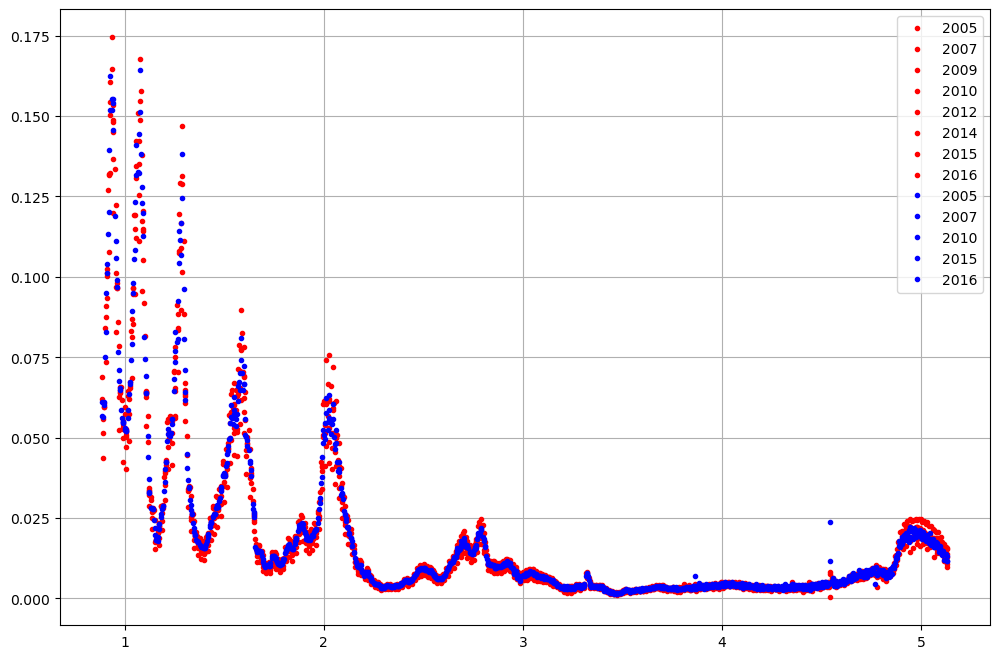

In [6]:
%matplotlib inline
plt.figure(facecolor='white',figsize=(12,8))
# plt.plot(ethane[:,0],(ethane[:,12]/1000)-.07,label='Ethane') # 13% ethane, 87% methane mixture
for i in range(len(orig_avgs)):
    plt.plot(vims_wave+orig_shifts[i],orig_avgs[i],'.',label=orig_years[i],c='red')
for i in range(len(avg_spectra)):
    plt.plot(vims_wave+wave_shifts[i,1],avg_spectra[i],'.',label=year_list[i],c='blue')
plt.legend()
plt.grid()
plt.show()

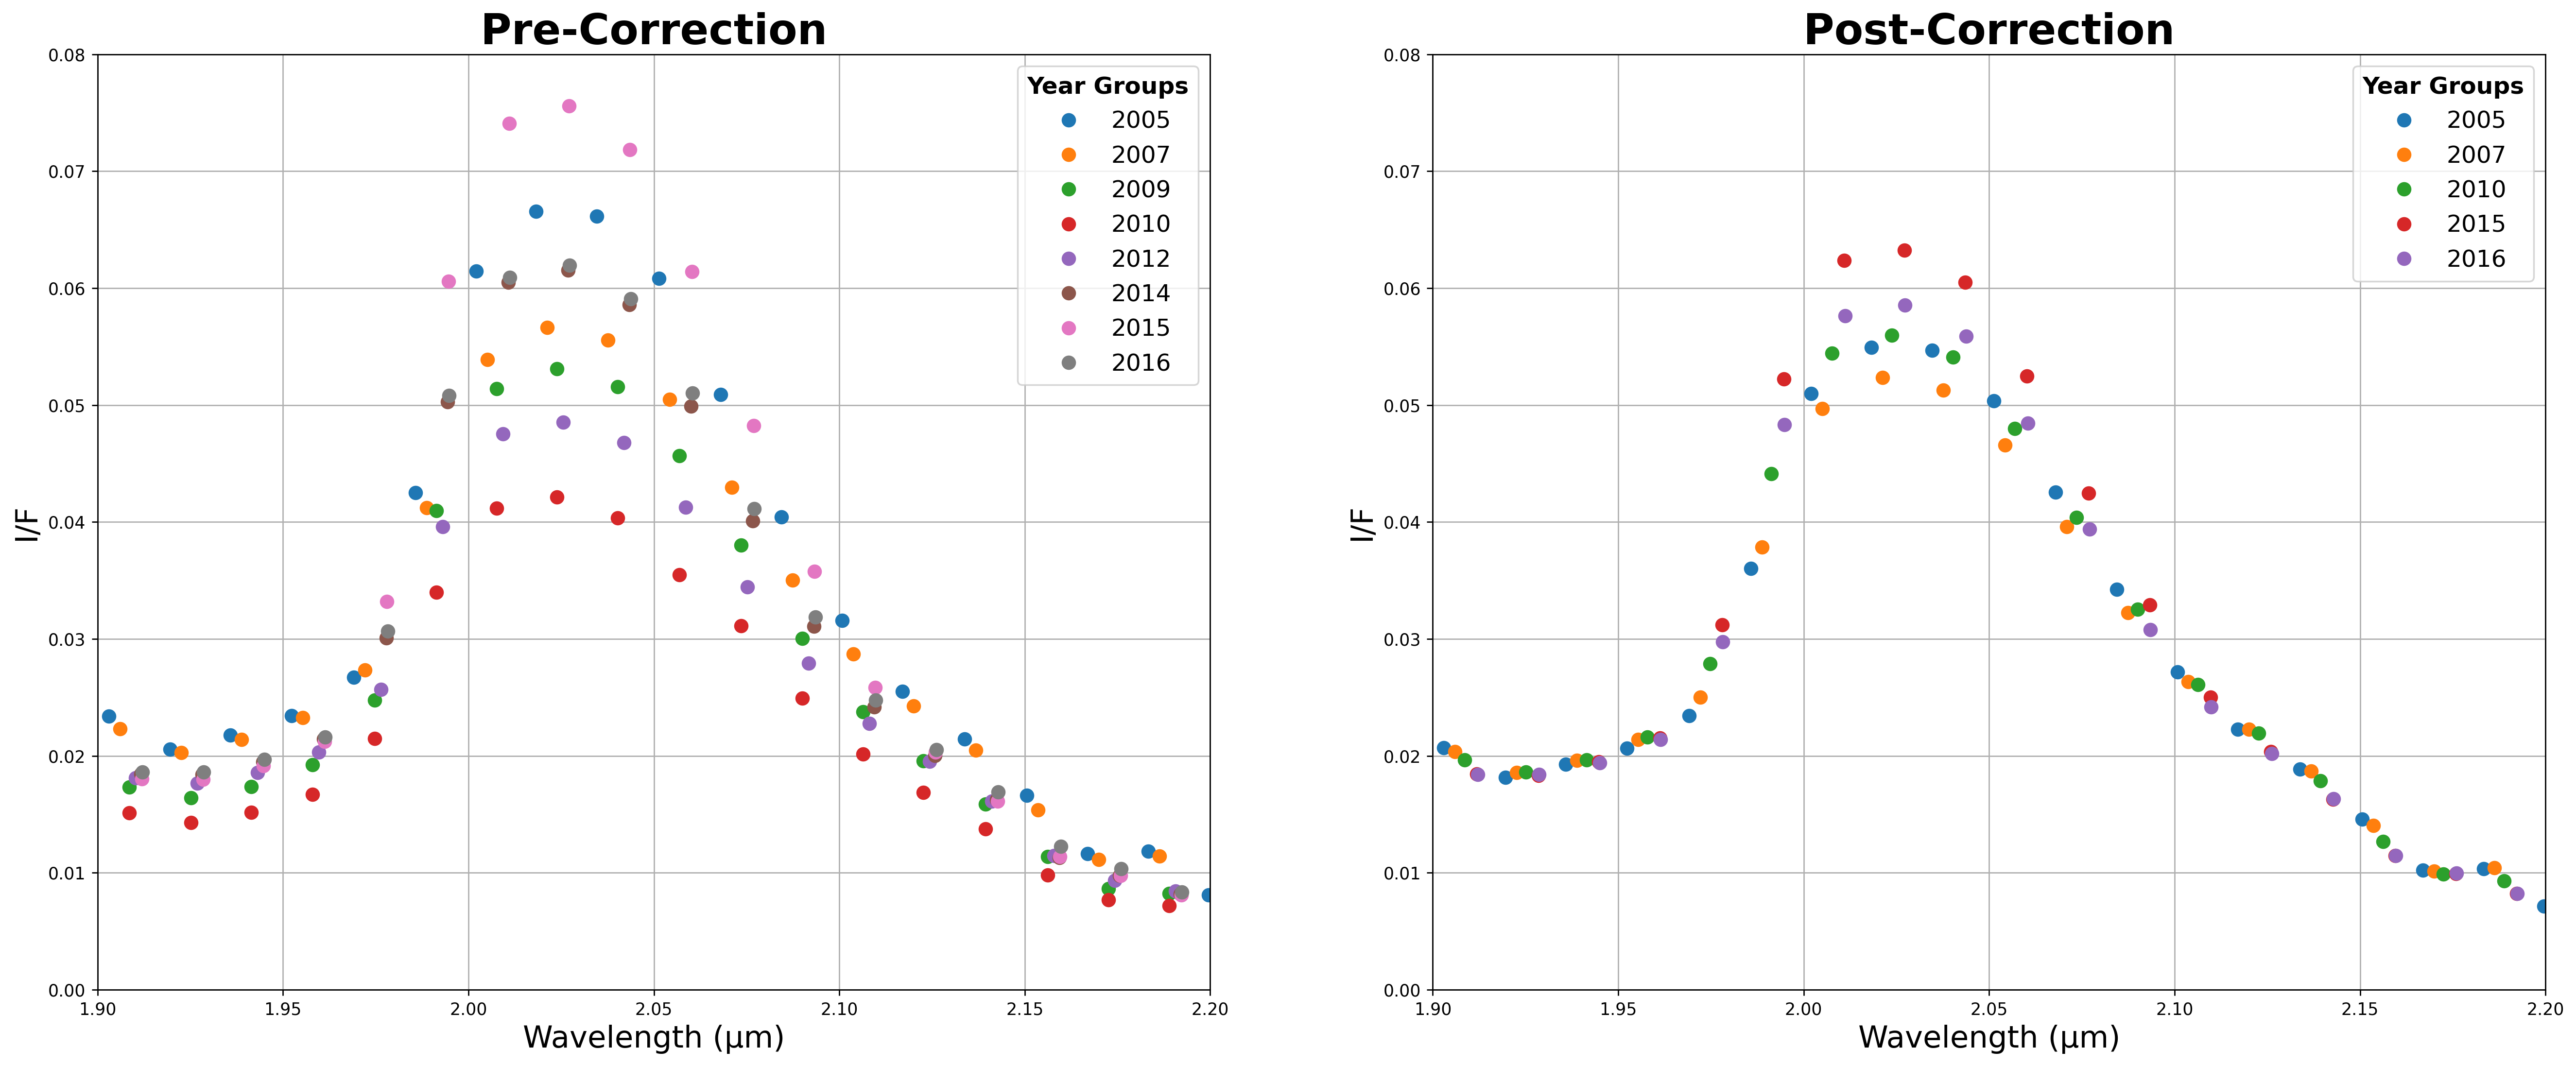

In [30]:
%matplotlib inline
fig,axs = plt.subplots(1,2,figsize=(26,10),facecolor='white',dpi=250)
for i in range(len(orig_avgs)):
    axs[0].plot(vims_wave+orig_shifts[i],orig_avgs[i],'.',label=orig_years[i],markersize=15)
axs[0].set_title('Pre-Correction',fontsize=25,fontweight='bold')
axs[0].set_xlabel('Wavelength (µm)',fontsize=18)
axs[0].set_ylabel('I/F',fontsize=18)
axs[0].grid()
legend0 = axs[0].legend(prop={'size':14}).set_title('Year Groups',prop={'size':14,'weight':'bold'})
axs[0].set_xlim([1.9,2.2])
axs[0].set_ylim([0,0.08])

for i in range(len(avg_spectra)):
    axs[1].plot(vims_wave+wave_shifts[i,1],avg_spectra[i],'.',label=year_list[i],markersize=15)
axs[1].set_title('Post-Correction',fontsize=25,fontweight='bold')
axs[1].set_xlabel('Wavelength (µm)',fontsize=18)
axs[1].set_ylabel('I/F',fontsize=18)
axs[1].grid()
axs[1].legend(prop={'size':14}).set_title('Year Groups',prop={'size':14,'weight':'bold'})
axs[1].set_xlim([1.9,2.2])
axs[1].set_ylim([0,0.08])
plt.savefig('C:\\Users\\lucas\\Downloads\\corFig.png',bbox_inches='tight')
plt.show()

In [ ]:
%matplotlib inline

layout = [['a)','b)']]

fig,axs = plt.subplot_mosaic(layout,figsize=(26,10),facecolor='white',dpi=250)

for i in range(len(orig_avgs)):
    axs['a)'].plot(vims_wave+orig_shifts[i],orig_avgs[i],'.',label=orig_years[i],markersize=15)
axs['a)'].set_title('Pre-Correction',fontsize=30,fontweight='bold')
axs['a)'].set_xlabel('Wavelength',fontsize=18)
axs['a)'].set_ylabel('I/F',fontsize=18)
axs['a)'].grid()
axs['a)'].legend()
axs['a)'].set_xlim([1.9,2.2])
axs['a)'].set_ylim([0,0.08])

for i in range(len(avg_spectra)):
    axs['b)'].plot(vims_wave+wave_shifts[i,1],avg_spectra[i],'.',label=year_list[i],markersize=15)
axs['b)'].set_title('Post-Correction',fontsize=30,fontweight='bold')
axs['b)'].set_xlabel('Wavelength',fontsize=18)
axs['b)'].set_ylabel('I/F',fontsize=18)
axs['b)'].grid()
axs['b)'].legend()
axs['b)'].set_xlim([1.9,2.2])
axs['b)'].set_ylim([0,0.08])

for label,ax in axs.items():
    #label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72,-5/72,fig.dpi_scale_trans)
    ax.text(0.0,1.0,label,transform=ax.transAxes + trans,fontsize=30,fontweight='bold',verticalalignment='top',bbox=dict(facecolor='none',edgecolor='none',pad=3.0))

plt.savefig('C:\\Users\\lucas\\Downloads\\fig4.png',bbox_inches='tight')

In [9]:
for i in range(5):
    print(wave_shifts[i,1]-wave_shifts[i-1,1])

-0.0091
0.0029999999999999996
0.0026000000000000003
0.003300000000000001
0.0001999999999999988


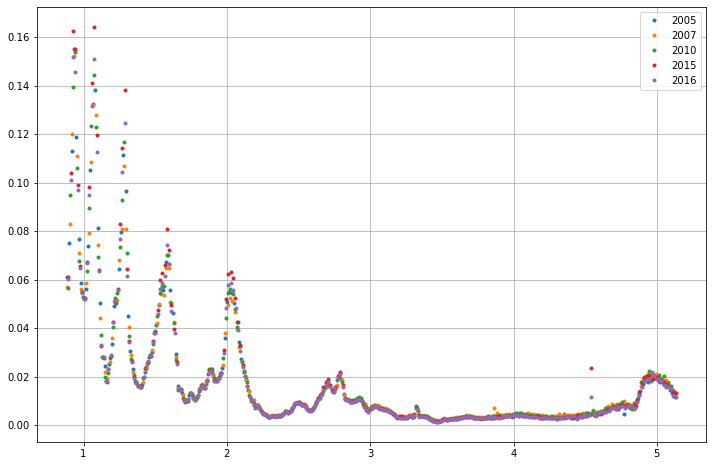

In [10]:
%matplotlib inline
plt.figure(facecolor='white',figsize=(12,8))
for i in range(len(avg_spectra)):
    plt.plot(vims_wave+wave_shifts[i,1],avg_spectra[i],'.',label=year_list[i])
plt.legend()
plt.grid()
plt.show()

In [11]:
vector_2 = []
for i in range(8):
    vector_2.extend(vims_wave+orig_shifts[i])

vector_2 = np.sort(vector_2)

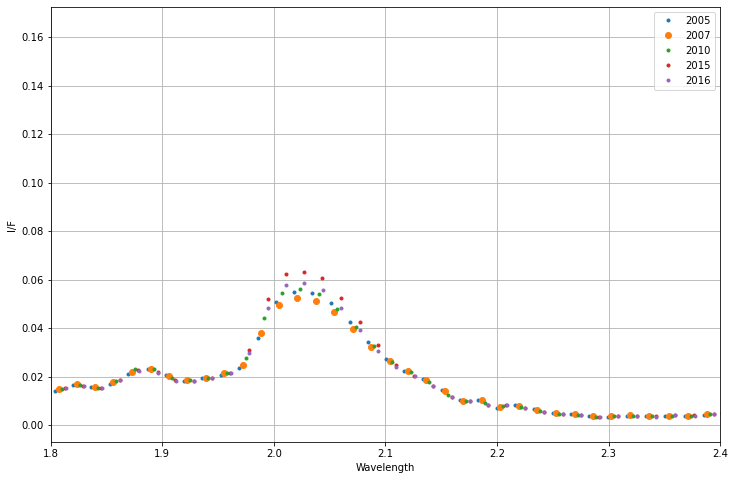

In [18]:
%matplotlib inline
plt.figure(facecolor='white',figsize=(12,8))
for i in range(len(avg_spectra)):
    if i == 1:
        plt.plot(vims_wave+wave_shifts[i,1],avg_spectra[i],'.',label=year_list[i],markersize=12)
    else:
        plt.plot(vims_wave+wave_shifts[i,1],avg_spectra[i],'.',label=year_list[i])
plt.xlim([1.8,2.4])
plt.xlabel('Wavelength')
plt.ylabel('I/F')
plt.legend()
plt.grid()
plt.show()

In [ ]:
avg_spectra = np.asarray(avg_spectra)

In [ ]:
newList = []
for j,group in enumerate(avg_spectra):
    for i,spectrum in enumerate(group):
        newList.append([])


In [ ]:
avg_spectra

#### Figure 3 - Five year groups

In [ ]:
%matplotlib inline
plt.figure(facecolor='white',figsize=(12,8))
for year in range(2004,2018):
    start_date = Time(str(year)+'-01-01T00:00:00.00',format='isot').jd
    end_date = Time(str(year)+'-12-31T00:00:00.00',format='isot').jd
    inds = np.where((start_vals >= start_date) & (start_vals <= end_date))[0]
    plt.bar(year,len(inds))
plt.xticks(range(2004,2018))
plt.grid()
plt.show()

#### Figure 4 - show resolution improvement before and after

In [24]:
p = np.polyfit(acetylene[:,0],acetylene[:,1],1)
acetylene[:,1] -= np.polyval(p,acetylene[:,0]) # puts on same y-plane as spectra (adds atmosphere if you will)

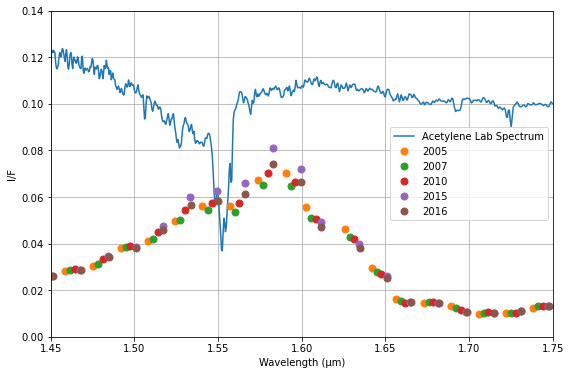

In [28]:
%matplotlib inline
plt.figure(facecolor='white',figsize=(9,6))
# plt.plot(tholins[:,0],tholins[:,1])
plt.plot(acetylene[:,0],(acetylene[:,1]/10)+.1,label='Acetylene Lab Spectrum')
for i in range(len(avg_spectra)):
    plt.plot(vims_wave+wave_shifts[i,1],avg_spectra[i],'.',label=year_list[i],markersize=14)
plt.legend()
plt.xlim([1.45,1.75])
plt.ylim([0,0.14])
plt.xlabel('Wavelength (µm)')
plt.ylabel('I/F')
plt.grid()
plt.show()

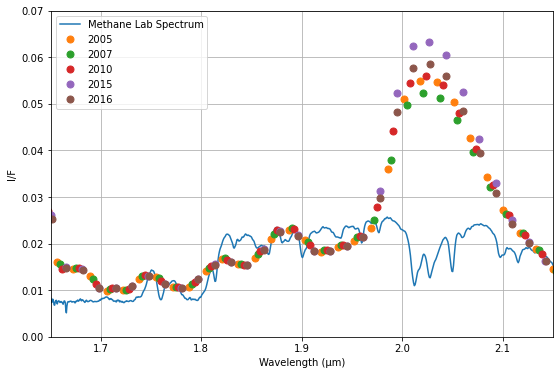

In [26]:
%matplotlib inline
plt.figure(facecolor='white',figsize=(9,6))
# plt.plot(tholins[:,0],tholins[:,1])
plt.plot(ethane[:,0],(ethane[:,14]/1000)-.07,label='Methane Lab Spectrum')
for i in range(len(avg_spectra)):
    plt.plot(vims_wave+wave_shifts[i,1],avg_spectra[i],'.',label=year_list[i],markersize=14)
plt.legend()
plt.xlim([1.65,2.15])
plt.ylim([0,0.07])
plt.xlabel('Wavelength (µm)')
plt.ylabel('I/F')
plt.grid()
plt.show()

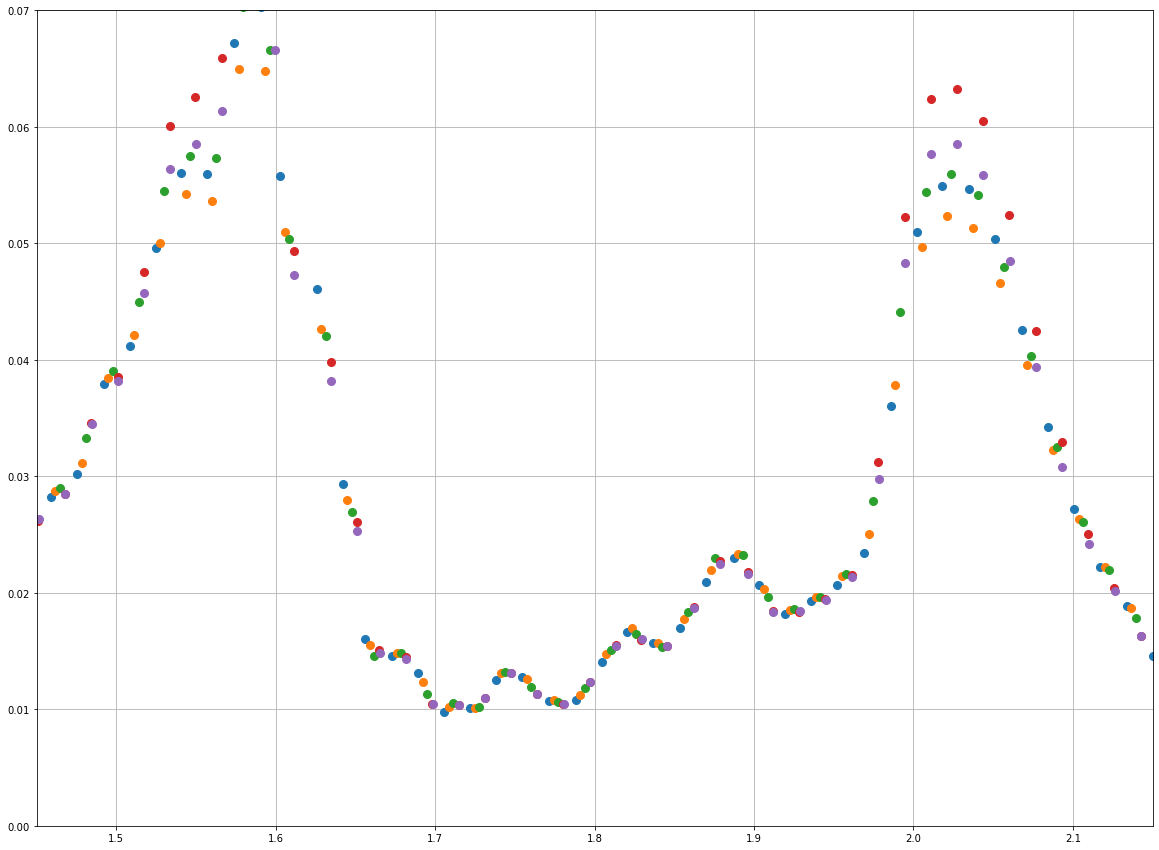

In [36]:
%matplotlib inline
fig,ax = plt.subplots(facecolor='white',figsize=(20,15))
for i in range(len(avg_spectra)):
    ax.plot(vims_wave+wave_shifts[i,1],avg_spectra[i],'.',label=year_list[i],markersize=16)
plt.xlim([1.45,2.15])
plt.ylim([0,0.07])
ax.grid()

#Create set of inset axes: should fill the bounding box allocated to them
ax2 = plt.axes([0,0,1,1])
#Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition()
plt.show()